In [5]:
#/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/Gr_density/Gr_new.ipynbb

In [6]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
import matplotlib.pyplot as plt
import alphashape
import trimesh

In [7]:
from scipy.spatial import distance_matrix
def density_between_distances(X, center, start_dist, end_dist):    
    distances = distance_matrix(center, X)[0]
    in_shell = (distances <= end_dist) & (distances > start_dist)
    shell_vol = 4/3 * np.pi * (end_dist**3 - start_dist**3)
    density = np.sum(in_shell) / shell_vol
    return density

In [8]:
from tqdm import tqdm  # 确保导入 tqdm

def compute_density(tdg, start_dist, end_dist):
    X = tdg[['x', 'y', 'z']].values
    
    raw_density = []
    for index, center in tqdm(tdg.iterrows(), total=tdg.shape[0]):  # 使用 tqdm 包装迭代器并指定总数
        center_coords = np.array([center['x'], center['y'], center['z']])
        density = density_between_distances(X, [center_coords], start_dist=start_dist, end_dist=end_dist)
        raw_density.append(density)
        
    result = pd.DataFrame({'start':tdg['start'], 'density':raw_density})
    
    return result

# test

In [9]:
cell = "d4A50"
res = "200k"
path = "/share/Data/hxie/project/202209/esc_xwliu/esc0312_tidyup/structure/reRun_3D/processed/{}/3d_info/clean.{}.0.3dg".format(cell, res)
tdg = pd.read_csv(path, sep = "\t", comment = "#", header = None)
tdg.columns = ["chr", "start", "x", "y", "z"]
tdg = tdg.query('chr == "chrX(mat)"')

In [10]:
res_test1 = compute_density(tdg, start_dist = 0, end_dist = 3)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 628/628 [00:00<00:00, 6296.73it/s]


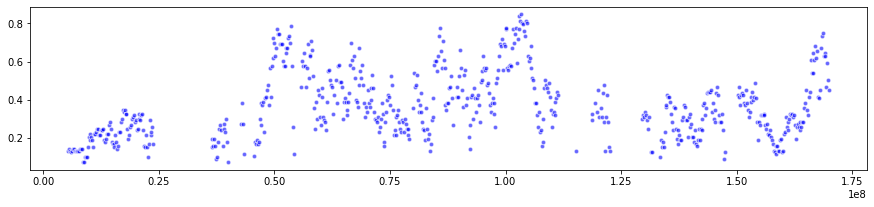

In [11]:
plt.figure(figsize=(15, 3))
plt.scatter(res_test1['start'], res_test1['density'], color='blue', alpha=0.6, edgecolors='w', s=20)

In [12]:
cell = "d4A50"
res = "200k"
path = "/share/Data/hxie/project/202209/esc_xwliu/esc0312_tidyup/structure/reRun_3D/processed/{}/3d_info/clean.{}.0.3dg".format(cell, res)
tdg = pd.read_csv(path, sep = "\t", comment = "#", header = None)
tdg.columns = ["chr", "start", "x", "y", "z"]
tdg = tdg.query('chr == "chrX(pat)"')

In [14]:
res_test2 = compute_density(tdg, start_dist = 0, end_dist = 3)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 645/645 [00:00<00:00, 6743.05it/s]


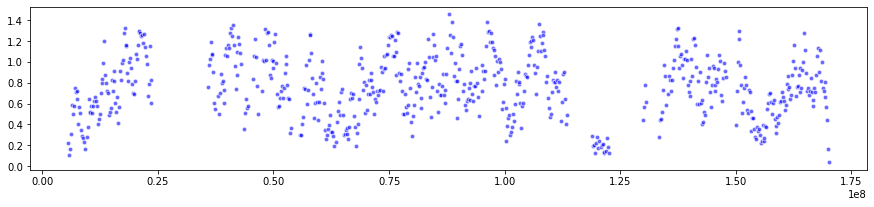

In [15]:
plt.figure(figsize=(15, 3))
plt.scatter(res_test2['start'], res_test2['density'], color='blue', alpha=0.6, edgecolors='w', s=20)

# cal my data

In [16]:
metadata = pd.read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc1014_halfday/RNA_analysis/s1014_metadata_X_noM_noXistneg.csv")
metadata = metadata.query('cellname != "d4A8"')
rmsd = pd.read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0312_tidyup/structure/reRun_3D/stat/rmsd.csv", index_col = 0)
rmsd = rmsd.query('`20k` <= 1.5')

cellnames = metadata['cellname'].values
cellnames = [x for x in cellnames if x in rmsd['cellname'].values]

In [17]:
import multiprocessing as mp

def compute_density_single(cell, res, chr_name, start_dist, end_dist):
    path = "/share/Data/hxie/project/202209/esc_xwliu/esc0312_tidyup/structure/reRun_3D/processed/{}/3d_info/clean.{}.0.3dg".format(cell, res)
    tdg = pd.read_csv(path, sep="\t", comment="#", header=None)
    tdg.columns = ["chr", "start", "x", "y", "z"]
    tdg = tdg.query(f'chr == "{chr_name}"')
    density_per_cell = compute_density(tdg, start_dist, end_dist)
    density_per_cell = density_per_cell.rename(columns={'density': cell})
    return density_per_cell

In [18]:
def compute_density_all(cellnames, res, chr_name, start_dist=0, end_dist=3, n_processes=None):
    if n_processes is None:
        n_processes = mp.cpu_count()

    pool = mp.Pool(processes=n_processes)
    results = [pool.apply_async(compute_density_single, args=(cell, res, chr_name, start_dist, end_dist)) for cell in cellnames]
    
    density_all = results[0].get()
    for r in results[1:]:
        density_all = pd.merge(density_all, r.get(), on='start', how='outer')

    # density_all = density_all.sort_values('start')

    return density_all

In [19]:
density_all = compute_density_all(cellnames, res='200k', chr_name="chrX(mat)", start_dist=0, end_dist=3, n_processes=None)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 581/581 [00:00<00:00, 2544.70it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 619/619 [00:00<00:00, 3454.32it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 667/667 [00:00<00:00, 2943.06it/s]


In [20]:
density_all = density_all.sort_values('start')

In [21]:
density_all.to_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/Gr_density_new/res/Cast_chrX_0_3_notnorm.csv", index=False)

In [22]:
density_all2 = compute_density_all(cellnames, res='200k', chr_name="chrX(pat)", start_dist=0, end_dist=3, n_processes=None)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 615/615 [00:00<00:00, 2231.15it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 653/653 [00:00<00:00, 3444.79it/s]


In [23]:
density_all2 = density_all2.sort_values('start')

In [24]:
density_all2

,start,d0A1,d0A14,d0A16,d0A17,d0A2,d0A21,d0A22,d0A24,d0A28,...,d4C40,d4C56,d4C57,d4C6,d4C79,d4C83,d4C91,d4C97,d15D16,d15D96
687,2800000,NaN,NaN,NaN,NaN,0.035368,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
688,3000000,NaN,NaN,NaN,NaN,0.035368,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
689,3200000,NaN,NaN,NaN,NaN,0.035368,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
690,3400000,NaN,NaN,NaN,NaN,0.035368,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
691,3600000,NaN,NaN,NaN,NaN,0.035368,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,170000000,0.530516,0.583568,0.583568,0.574726,0.539358,0.397887,0.167997,0.274100,0.778091,...,0.424413,0.300626,0.106103,0.63662,1.423553,0.04421,0.512833,0.415571,0.848826,0.424413
652,170200000,NaN,0.265258,NaN,0.353678,0.344836,0.247574,0.061894,0.114945,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.238732,0.751565,NaN
793,170400000,NaN,NaN,NaN,NaN,0.212207,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
803,170600000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
density_all

,start,d0A1,d0A14,d0A16,d0A17,d0A2,d0A21,d0A22,d0A24,d0A28,...,d4C40,d4C56,d4C57,d4C6,d4C79,d4C83,d4C91,d4C97,d15D16,d15D96
692,4200000,NaN,NaN,NaN,NaN,0.026526,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
693,4400000,NaN,NaN,NaN,NaN,0.026526,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
694,4600000,NaN,NaN,NaN,NaN,0.044210,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
695,4800000,NaN,NaN,NaN,NaN,0.132629,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
696,5000000,NaN,NaN,NaN,NaN,0.309468,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,169600000,0.389045,0.804617,0.327152,0.592410,0.221049,0.769249,0.804617,0.601252,0.663146,...,0.265258,0.468623,0.530516,0.592410,0.132629,0.707355,0.132629,0.548200,0.503991,0.256416
601,169800000,0.362520,0.618936,0.486307,0.530516,0.123787,0.751565,0.627778,0.309468,0.610094,...,0.247574,0.530516,0.583568,0.495149,0.061894,0.857668,NaN,0.512833,0.362520,0.380203
602,170000000,0.433255,0.539358,0.274100,0.442097,0.079577,0.397887,0.318310,0.203365,NaN,...,0.141471,0.530516,0.380203,0.247574,0.159155,0.946088,NaN,0.389045,0.256416,0.424413
603,170200000,0.353678,0.274100,NaN,0.415571,0.079577,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.831142,NaN,NaN,NaN,NaN


In [26]:
density_all2.to_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/Gr_density_new/res/B6_chrX_0_3_notnorm.csv", index=False)